# Plots 

Plots Notebook for batch size optimal calculation for generated dense datasets.

## Generated Dataset Visualization

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import math

In [3]:
df = pd.read_csv('../data/generated_dense_batch_size.csv')

In [7]:
def get_category(x):
    return f'{x["ID"]}_{x["batch_size"]}'

def get_category_lookup(x):
    return f'{x["ID"]}_500'

def vlookup(df, x):
    try:
        return df.set_index('ID_full').loc[x['vlookup_cated'], 'mean_sequential']
    except:
        # Skip values when batch size 500 is the same as lower batch sizes
        return x['mean_sequential']

In [8]:
df['ID_full'] = df.apply(get_category, axis=1)

In [9]:
df['vlookup_cated'] = df.apply(get_category_lookup, axis=1)
    
df['base'] = df.apply(lambda x: vlookup(df, x), axis=1)
df['acceleration'] = df['base'] / df['mean_sequential']

In [10]:
df[df['ID_full'] == '10000_1000_100']['mean_sequential']

86    1.856841e+08
Name: mean_sequential, dtype: float64

In [11]:
df[df['ID_full'] == '10000_1000_500']['mean_sequential']

82    1.639936e+08
Name: mean_sequential, dtype: float64

In [12]:
df['vlookup_cated']

0         100_10_500
1         100_10_500
2         100_10_500
3         100_10_500
4         100_10_500
           ...      
82    10000_1000_500
83    10000_1000_500
84    10000_1000_500
85    10000_1000_500
86    10000_1000_500
Name: vlookup_cated, Length: 87, dtype: object

In [78]:
df[df.batch_size.isin([100, 500, 1000, 5000, 10000])].to_csv('generated_dense_batch_size.csv')

In [13]:
df.loc[df['method'] == 'pythonic', 'mean_sequential'] *= 24
df.loc[df['method'] == 'pythonic', 'mean_reinit'] *= 24
df.loc[df['method'] == 'pythonic', 'logMeanTime'] += np.log10(24)
df.loc[df['method'] == 'pythonic', 'logMeanTimeReinit'] += np.log10(24)

In [14]:
matrices = {
    'kendall': {},
}

matrices_sequential = {
    'kendall': {},
    'euclidean': {},
    'pearson': {},
}

labels = {
    'kendall': {},
    'euclidean': {},
    'pearson': {},
}

labels_sequential = {
    'kendall': {},
    'euclidean': {},
    'pearson': {},
}

In [15]:
def fill_missing_values(matrix):
    for i in range(1, 5):
        try:
            matrix.loc[i]
        except:
            print(i)
            matrix.loc[i] = [np.nan, np.nan, np.nan, np.nan, np.nan]
    
    labels = np.round(np.copy(matrix), 1).tolist()
    for i in range(1, 5):
        for j in range(1, 6):
            if i + j <= 7 and np.isnan(matrix.loc[i, j]):
                label_i = i - 1
                label_j = j - 1
                matrix.loc[i, j] = 100
                labels[label_i][label_j] = 'W'
    matrix = matrix.loc[matrix.index[::-1]]
    labels = labels[::-1]
#     print(labels)
    return matrix, labels

In [16]:
matrices

{'kendall': {}}

In [17]:
for metric in matrices.keys():
    for num_batches in [1, 2, 5, 10, 20]:
        
#         print(metric, method)
        matrix = df[df.metric == metric]
        matrix_log = matrix[matrix.num_batches == num_batches].pivot('logWX','logWY','logMeanTimeReinit')
        matrix_sequential = matrix[matrix.num_batches == num_batches].pivot('logWX', 'logWY', 'logMeanTime')
        # print(metric, method, num_batches)
        
        matrix, label = fill_missing_values(matrix_log)
        matrix_sequential, label_sequential = fill_missing_values(matrix_sequential)
        
        matrix.index = matrix.index.astype(int)
        matrix.columns = matrix.columns.astype(int)
        
        matrix_sequential.index = matrix_sequential.index.astype(int)
        matrix_sequential.columns = matrix_sequential.columns.astype(int)
        
        matrices_sequential[metric][num_batches] = matrix_sequential
        matrices[metric][num_batches] = matrix
        labels[metric][num_batches] = label
        labels_sequential[metric][num_batches] = label_sequential

1
1


In [18]:
import matplotlib.pyplot as plt

In [19]:
import seaborn as sns

In [20]:
cmap = sns.color_palette('coolwarm', as_cmap=True)

In [21]:
import matplotlib as mpl


In [23]:
methods = ['amap', 'factoextra', 'pythonic', 'pandas', 'CPU', 'GPU', 'sparse_CPU', 'sparse_GPU']

palette = sns.palettes.color_palette()[:len(methods)]
color_palette = {
    method: pallete for method, pallete in zip(methods, palette)
}

In [24]:
sparse_methods = ['amap', 'factoextra', 'pythonic', 'pandas', 'dense_CPU', 'dense_GPU', 'sparse_CPU', 'sparse_GPU']

palette = sns.palettes.color_palette()[:len(methods)]
sparse_color_palette = {
    method: pallete for method, pallete in zip(sparse_methods, palette)
}

In [26]:
df = df[df['|W|'] > 10000]

In [27]:
hue_order = ['amap', 'factoextra', 'pandas','pythonic','CPU','GPU']

In [28]:
TESTED_METHODS = hue_order

### Checking for wall-timed methods and add the to analysis

In [29]:
df = df[df['|W|'] > 10000]
index = 1000
df_missed = df.copy()

for method in TESTED_METHODS:
    for metric in ['euclidean', 'pearson', 'kendall']:
        for wX in [10, 100, 1000, 10000]:
            for wY in [10, 100, 1000, 10000, 100000]:
                if wX * wY > 10 ** 7 or wX * wY < 10 ** 5:
                    continue
                df_filtered = df[
                    (df.method == method) & (df.wX == wX) & (df.wY == wY) & (df.metric == metric)
                ]
                if df_filtered.shape[0] > 0:
                    continue
                df_missed.loc[index] = {
                    'metric': metric,
                    'method': method,
                    'wX': wX,
                    'wY': wY,
                    'ID': f'{wX}_{wY}',
                    '|W|': wX * wY,
                    'logWX': np.log10(wX),
                    'logWY': np.log10(wY),
                    'logMeanTime': 11.0,
                    'logMeanTimeReinit': 11.0,
                    'mean_reinit': 10 ** 11.0,
                    'mean_sequential': 10 ** 11.0,
                }
                index += 1

In [38]:
df['ID2'] = df['ID']+'_'+df['metric']
df_missed['ID2'] = df_missed['ID'] + '_' + df_missed['metric']

In [41]:
df_acc['logAcceleration_reinit'] = np.log10(df_acc['acceleration_reinit'])
df_acc['logAcceleration_sequential'] = np.log10(df_acc['acceleration_sequential'])
df_acc['|W|'] = df_acc['wX']*df_acc['wY']
df_acc['Method'] = df_acc['metric']+'_'+df_acc['method']

In [42]:
TESTED_METHODS = ["pythonic","pandas","factoextra","amap", "CPU",]

In [43]:
from matplotlib.patches import PathPatch, Rectangle

In [44]:
df.loc[df.method == 'CPU', 'method'] = 'GADES-CPU-dense'
df.loc[df.method == 'GPU', 'method'] = 'GADES-GPU-dense'

df_acc.loc[df_acc.method == 'CPU', 'method'] = 'GADES-CPU-dense'
df_acc.loc[df_acc.method == 'GPU', 'method'] = 'GADES-GPU-dense'

df_missed.loc[df_missed.method == 'CPU', 'method'] = 'GADES-CPU-dense'
df_missed.loc[df_missed.method == 'GPU', 'method'] = 'GADES-GPU-dense'
color_palette['GADES-CPU-dense'] = color_palette['CPU']
color_palette['GADES-GPU-dense'] = color_palette['GPU']

for dataframe in [df, df_acc, df_missed]:
    dataframe.loc[dataframe.method == 'pythonic', 'method'] = 'scipy'
    
color_palette['pythonic'] = 'scipy'

In [45]:
TESTED_METHODS = ['scipy', 'pandas', 'factoextra', 'amap', 'GADES-CPU-dense']

In [46]:
import os

In [47]:
def normalize(x):
    
    mapping = [10 ** 5, 10 ** 6, 10 ** 7]
    results = [5, 6, 7]
    
    values = {
        element: value for element, value in zip(mapping, results)
    }
    return f'$10^{values[x]}$'

In [15]:
import os

In [48]:
df_sparse = pd.read_csv('../data/sparse_generated_batch_size.csv')

In [49]:
df_sparse['logW'] = np.log10(df_sparse['|W|'])

In [50]:
df_sparse[df_sparse.num_batches == 20]

,DataFile,metric,method,wX,wY,ID,|W|,logWX,logWY,logMeanTime,...,maxTime,mean_reinit,mean_sequential,sd,Method,sparsity,batch_size,num_batches,val_2,logW
19,../results/GeneratedSparseBatchSizeFixed/10000...,kendall,GPU,10000,10,10000_10,100000,4.0,1.0,6.252425,...,1.844286e+06,1.844286e+06,1.788238e+06,56047.500,kendall_GPU,0.90,500,20.0,1.732191e+06,5.0
24,../results/GeneratedSparseBatchSizeFixed/10000...,kendall,GPU,10000,10,10000_10,100000,4.0,1.0,6.076216,...,1.210348e+06,1.210348e+06,1.191835e+06,18513.625,kendall_GPU,0.95,500,20.0,1.173321e+06,5.0
29,../results/GeneratedSparseBatchSizeFixed/10000...,kendall,GPU,10000,10,10000_10,100000,4.0,1.0,6.668705,...,4.690292e+06,4.690292e+06,4.663428e+06,26864.125,kendall_GPU,0.75,500,20.0,4.636564e+06,5.0
34,../results/GeneratedSparseBatchSizeFixed/10000...,kendall,GPU,10000,10,10000_10,100000,4.0,1.0,5.993583,...,1.011913e+06,1.011913e+06,9.853320e+05,26581.000,kendall_GPU,0.99,500,20.0,9.587510e+05,5.0
39,../results/GeneratedSparseBatchSizeFixed/10000...,kendall,GPU,10000,10,10000_10,100000,4.0,1.0,7.047525,...,1.117713e+07,1.117713e+07,1.115642e+07,20704.125,kendall_GPU,0.50,500,20.0,1.113572e+07,5.0
64,../results/GeneratedSparseBatchSizeFixed/10000...,kendall,GPU,10000,100,10000_100,1000000,4.0,2.0,6.416696,...,2.646187e+06,2.646187e+06,2.610334e+06,35852.750,kendall_GPU,0.90,500,20.0,2.574482e+06,6.0
69,../results/GeneratedSparseBatchSizeFixed/10000...,kendall,GPU,10000,100,10000_100,1000000,4.0,2.0,6.183106,...,1.532374e+06,1.532374e+06,1.524425e+06,7948.625,kendall_GPU,0.95,500,20.0,1.516476e+06,6.0
74,../results/GeneratedSparseBatchSizeFixed/10000...,kendall,GPU,10000,100,10000_100,1000000,4.0,2.0,6.989075,...,9.782767e+06,9.782767e+06,9.751587e+06,31179.500,kendall_GPU,0.75,500,20.0,9.720408e+06,6.0
79,../results/GeneratedSparseBatchSizeFixed/10000...,kendall,GPU,10000,100,10000_100,1000000,4.0,2.0,6.022363,...,1.064532e+06,1.041152e+06,1.052842e+06,11689.750,kendall_GPU,0.99,500,20.0,1.064532e+06,6.0
84,../results/GeneratedSparseBatchSizeFixed/10000...,kendall,GPU,10000,100,10000_100,1000000,4.0,2.0,7.468746,...,2.957236e+07,2.957236e+07,2.942698e+07,145386.125,kendall_GPU,0.50,500,20.0,2.928159e+07,6.0


In [51]:
df_sparse['ID_full'] = df_sparse.apply(lambda x: f'{x["ID"]}_{x["sparsity"]}_{x["batch_size"]}', axis=1)

In [52]:
def get_category(x):
    return f'{x["ID"]}_{x["sparsity"]}_{x["batch_size"]}'

def get_category_lookup(x):
    return f'{x["ID"]}_{x["sparsity"]}_500'

def vlookup(df, x):
    try:
        return df.set_index('ID_full').loc[x['vlookup_cated'], 'mean_sequential']
    except:
        # Skip values when batch size 500 is the same as lower batch sizes
        return x['mean_sequential']

In [53]:
df_sparse.columns

Index(['DataFile', 'metric', 'method', 'wX', 'wY', 'ID', '|W|', 'logWX',
       'logWY', 'logMeanTime', 'logMeanTimeReinit', 'logMinTime', 'logMaxTime',
       'minTime', 'maxTime', 'mean_reinit', 'mean_sequential', 'sd', 'Method',
       'sparsity', 'batch_size', 'num_batches', 'val_2', 'logW', 'ID_full'],
      dtype='object')

In [54]:
df_sparse['vlookup_cated'] = df_sparse.apply(get_category_lookup, axis=1)
    
df_sparse['base'] = df_sparse.apply(lambda x: vlookup(df_sparse, x), axis=1)
df_sparse['acceleration'] = df_sparse['base'] / df_sparse['mean_sequential']

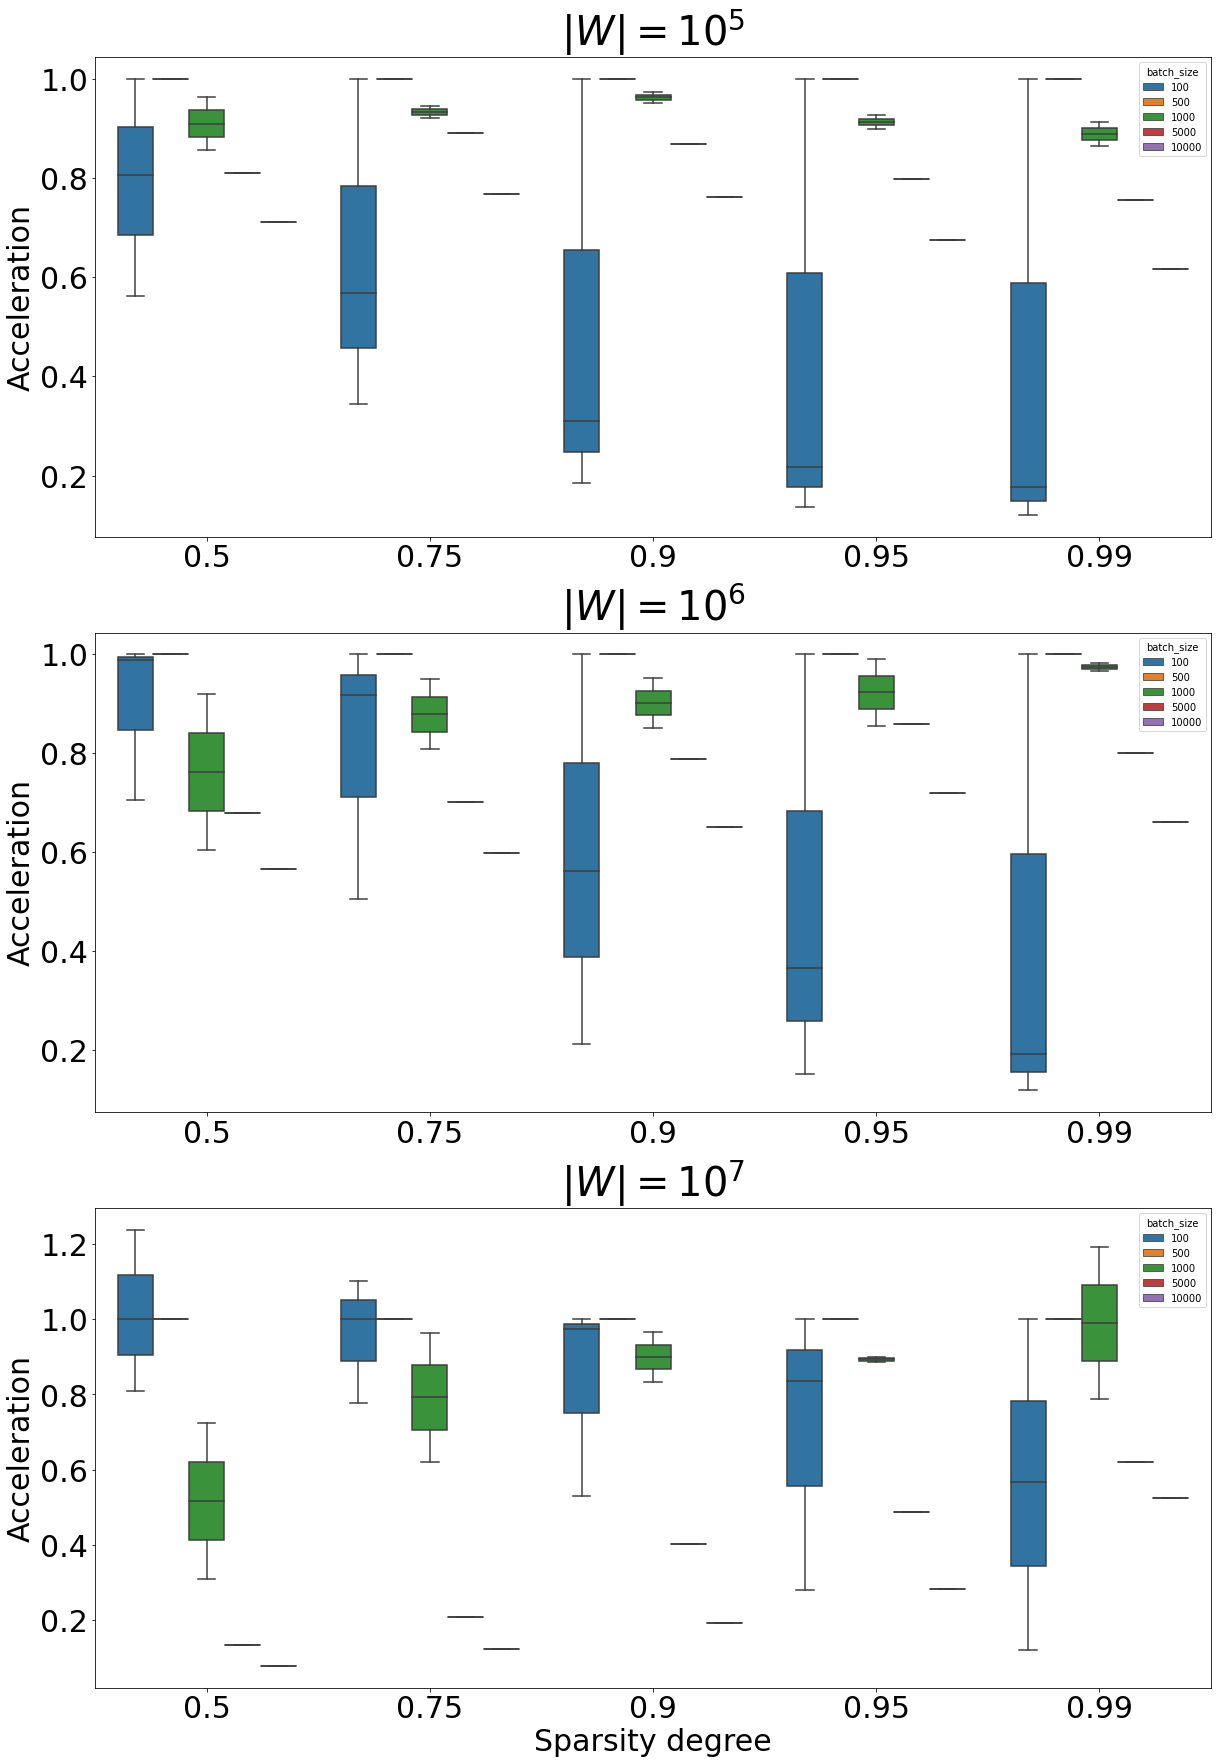

In [55]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))

num_counts = [100000, 10 ** 6, 10 ** 7]
FONT_SIZE=20
for index, current_ax in enumerate(ax):
    num_count = num_counts[index]
    plot = sns.boxplot(ax=current_ax, data=df_sparse[df_sparse['|W|'] == num_count], x='sparsity', hue='batch_size', y='acceleration')
    
    plot.set_title(f'$|W| = 10^{np.log10(num_count).astype(int)}$', fontsize=FONT_SIZE * 2)
    xlabel = '' if index < 2 else 'Sparsity degree'
    plot.set_xlabel(xlabel, fontsize=FONT_SIZE * 1.5)
    # ylabel = ylabel if jndex == 0 else ''
    plot.set_ylabel('Acceleration', fontsize=FONT_SIZE * 1.5)
    current_ax.tick_params(labelsize=FONT_SIZE * 1.5)

fig.savefig('suppfigure3.png', bbox_inches='tight', dpi=200)

In [56]:
df_sparse.to_csv('generated_sparse_batch_size.csv')